In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/NSE-TATAGLOBAL.csv')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset



In [4]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/NSE-TATAGLOBAL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()



In [5]:
# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))


In [8]:
class StockDataset(Dataset):
    def __init__(self, data, seq_length): # Use __init__ for the constructor
        self.data = data
        self.seq_length = seq_length

    def __len__(self): # Use __len__ for the length method
        return len(self.data) - self.seq_length

    def __getitem__(self, index): # Use __getitem__ for the item retrieval method
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



In [9]:
# Prepare the dataset and dataloader
dataset = StockDataset(scaled_data, sequence_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers): # Changed _init_ to __init__
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=1, hidden_size=50, output_size=1, num_layers=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
epochs = 25
for epoch in range(epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')


Epoch 1/25, Loss: 0.0039
Epoch 2/25, Loss: 0.0009
Epoch 3/25, Loss: 0.0013
Epoch 4/25, Loss: 0.0008
Epoch 5/25, Loss: 0.0010
Epoch 6/25, Loss: 0.0008
Epoch 7/25, Loss: 0.0007
Epoch 8/25, Loss: 0.0004
Epoch 9/25, Loss: 0.0009
Epoch 10/25, Loss: 0.0011
Epoch 11/25, Loss: 0.0011
Epoch 12/25, Loss: 0.0008
Epoch 13/25, Loss: 0.0003
Epoch 14/25, Loss: 0.0007
Epoch 15/25, Loss: 0.0003
Epoch 16/25, Loss: 0.0005
Epoch 17/25, Loss: 0.0004
Epoch 18/25, Loss: 0.0003
Epoch 19/25, Loss: 0.0003
Epoch 20/25, Loss: 0.0004
Epoch 21/25, Loss: 0.0002
Epoch 22/25, Loss: 0.0003
Epoch 23/25, Loss: 0.0001
Epoch 24/25, Loss: 0.0002
Epoch 25/25, Loss: 0.0004


In [13]:
# Predict future prices
model.eval()
test_data = scaled_data[-sequence_length:]
test_data = torch.tensor(test_data.reshape(1, sequence_length, 1), dtype=torch.float32)
predicted_price = model(test_data).detach().numpy()
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))

print(f"Predicted future price: {predicted_price[0][0]}")


Predicted future price: 231.11683654785156


<ipython-input-15-7fb62084c5d0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = scaler.inverse_transform(np.array(valid_sequences).reshape(-1, 1))


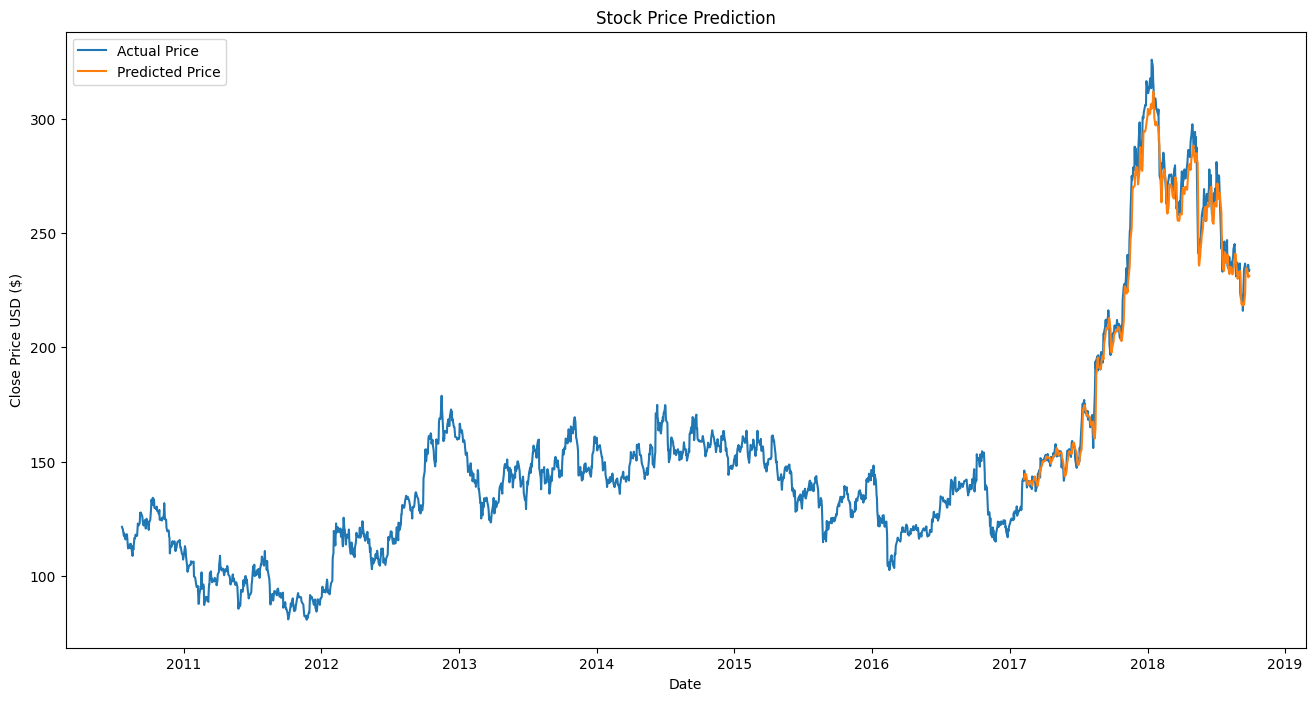

In [15]:
# Plot actual vs. predicted prices
train_size = int(len(df) * 0.8)
train = df[:train_size]
valid = df[train_size:]

# Generate predictions for the validation set
valid_sequences = []
# Start from 0 to cover all rows in 'valid'
for i in range(len(valid)):
    seq = scaled_data[train_size + i - sequence_length:train_size + i]
    seq = torch.tensor(seq.reshape(1, sequence_length, 1), dtype=torch.float32)
    pred = model(seq).detach().numpy()
    valid_sequences.append(pred[0][0])

valid['Predictions'] = scaler.inverse_transform(np.array(valid_sequences).reshape(-1, 1))

plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction')
plt.plot(df['Close'], label='Actual Price')
plt.plot(valid.index, valid['Predictions'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='best')
plt.show()